In [1]:
from importlib import reload
import random
from time import time
import numpy as np
import matplotlib.pyplot as plt
from cv2 import imread
import os
import pickle

In [2]:
import torch
from torch.utils.data import Dataset
import torch.nn as nn
import torch.nn.functional as F

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Connection to google drive for saving models

In [3]:
from google.colab import drive as gdrive
groot = '/content/gdrive/'
gdrive.mount(groot, force_remount=True)

Mounted at /content/gdrive/


# Loading Dataset

In [4]:
is_small_dataset = True # False

In [5]:
mnist_train_zip = 'mnist_train_small.zip' if is_small_dataset else 'mnist_train.zip'
mnist_test_zip = 'mnist_test_small.zip' if is_small_dataset else 'mnist_test.zip'

In [6]:
if is_small_dataset:
  !gdown "1GI5UeT_BiOGCsSUZtXL4LbEp4njvdFMJ&confirm=t"
  !unzip -q mnist_test_small.zip
  !rm -r test
  !mv mnist_test_small test
  !gdown "1e-rxeFk4_Y_peXjcG09SMWip6ZwagaLS&confirm=t"
  !unzip -q mnist_train_small.zip
  !rm -r train
  !mv mnist_train_small train

Downloading...
From: https://drive.google.com/uc?id=1GI5UeT_BiOGCsSUZtXL4LbEp4njvdFMJ&confirm=t
To: /content/mnist_test_small.zip
100% 18.3M/18.3M [00:00<00:00, 74.0MB/s]
rm: cannot remove 'test': No such file or directory
Downloading...
From: https://drive.google.com/uc?id=1e-rxeFk4_Y_peXjcG09SMWip6ZwagaLS&confirm=t
To: /content/mnist_train_small.zip
100% 36.7M/36.7M [00:00<00:00, 116MB/s] 
rm: cannot remove 'train': No such file or directory


In [7]:
if not is_small_dataset:
  !gdown "169Jlz1lsU6UBYc3V4nOQ5xQ6R9WMwRsj&confirm=t"
  !unzip -q mnist_test.zip
  !rm -r test
  !mv mnist_test test
  !gdown "1vB8QkeH2PAJ_Hd-q-UF5ffrmSh5w_4BO&confirm=t"
  !unzip -q mnist_train.zip
  !rm -r train
  !mv mnist_train train

Validation of the downloaded data

In [8]:
with open('train/labels.pck','rb') as f: labels_train = pickle.load(f)
with open('test/labels.pck','rb') as f: labels_test = pickle.load(f)
len(labels_train), len(labels_test)

(20000, 10000)

In [9]:
os.path.exists('train/labels.pck'),os.path.exists('test/labels.pck'),\
os.path.exists('train/0.raw'),os.path.exists('train/0.jpg'),os.path.exists('train/0.png'),\
os.path.exists('test/0.raw'),os.path.exists('test/0.jpg'),os.path.exists('test/0.png')

(True, True, True, True, True, True, True, True)

In [10]:
os.path.exists('train/19999.raw'),\
os.path.exists('train/19999.jpg'),\
os.path.exists('train/19999.png'),\
os.path.exists('test/9999.raw'),\
os.path.exists('test/9999.jpg'),\
os.path.exists('test/9999.png'),\
os.path.exists('train/59999.raw'),\
os.path.exists('train/59999.jpg'),\
os.path.exists('train/59999.png')

(True, True, True, True, True, True, False, False, False)

# Importing custom modules for experiments managment

In [11]:
module_name = "fiow"
module_token = "17i0L6nHi_4OqSOl-kwAC0_dOavr9Sj2S&confirm=t"
if os.path.exists(f'{module_name}.py'): os.remove(f'{module_name}.py')
os.system(f'gdown "{module_token}"');
try: fiow
except NameError: import fiow
else: reload(fiow)


  FORMATS for paths of FIOW module:
  cpath = './file name or path from here till file name'
  gpath = 'My\ Drive/further path till file name (use back slash before each space)'
  NOTE: For each type of paths there is different recommended beginning path symbol:
        cpath ./  
        gpath none
  Functions exported: wc, wg, gc, cg, wdown, wdowns, gup, gups, gdown, ipynb2py
  Doc notes you will get by standard Python 'help' function:
  e.g. help(wc)
  


In [12]:
ioc = fiow.ioc

In [13]:
if os.path.exists("xpm2.py"): os.remove("xpm2.py")

In [14]:
fiow.gdown("xpm2.py")
try:
  xpm2
except:
  import xpm2
else:
  reload(xpm2)
import datetime as dt

In [15]:
from xpm2 import EXP

# Data Augmentation preparation

In [16]:
def bgr2rgb(img):
  cimg = img[:,:,2].copy(); img[:,:,2] = img[:,:,0]; img[:,:,0] = cimg
  return img

In [17]:
!gdown "1z50AEH3GasLnyrIilWskjQbgz8Cxh4Uc&confirm=t"
!gdown "1bRy3wZfD45nuiPwVt-nc-pVo_oy8cGKT&confirm=t"

Downloading...
From: https://drive.google.com/uc?id=1z50AEH3GasLnyrIilWskjQbgz8Cxh4Uc&confirm=t
To: /content/imgtrans.py
100% 9.52k/9.52k [00:00<00:00, 35.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1bRy3wZfD45nuiPwVt-nc-pVo_oy8cGKT&confirm=t
To: /content/motyl.jpg
100% 51.8k/51.8k [00:00<00:00, 105MB/s]


In [18]:
import imgtrans as IT

In [19]:
reload(IT)

<module 'imgtrans' from '/content/imgtrans.py'>

### Bilinear interpolation in Cython

In [20]:
%reload_ext cython

In [21]:
%%cython
cimport cython
cimport numpy as np
def interpolate_bilinearly_cy(double ax, double bx, double cx,\
  double ay, double by, double cy, Py_ssize_t yres, Py_ssize_t xres, Py_ssize_t cres,\
        unsigned char[::1] buf_in, unsigned char[::1] buf_out,):
  cdef double xres1 = xres-1.0, yres1 = yres-1.0
  cdef double x, y, value
  cdef Py_ssize_t sx = cres, sy= cres*xres, sc= 1
  cdef Py_ssize_t i, j, k, iA, iB, jA, jC
  cdef double f_xa, f_xb, f_ya, f_yc
  cdef Py_ssize_t ofs, ksc
  k = 0; ofs = 0
  while k<cres:
    j = 0; ksc = ofs = k*sc; x = cx; y = cy
    while j<yres:
      i = 0; ofs = j*sy+ksc; x = j*bx+cx; y = j*by+cy
      while i<xres:
        xx = 0.0 if x<0.0 else xres1 if x>xres1 else x
        iA = int(xx); iB = iA+1 if (xx< xres1 and xx>0) else iA; f_xa = xx-iA; f_xb = iB-xx
        yy = 0.0 if y<0.0 else yres1 if y>yres1 else y
        jA = int(yy); jC = jA+1 if (yy<yres1 and yy>0) else jA; f_ya = yy-jA; f_yc = jC-yy
        value = f_xb*f_yc*buf_in[iA*sx+jA*sy+ksc] +\
                f_xa*f_yc*buf_in[iB*sx+jA*sy+ksc] +\
                f_xb*f_ya*buf_in[iA*sx+jC*sy+ksc] +\
                f_xa*f_ya*buf_in[iB*sx+jC*sy+ksc]
        value = 0.0 if value<0.0 else 255. if value>255. else value+0.5
        buf_out[ofs] = int(value)
        i += 1; ofs += sx; x += ax; y += ay
      j += 1; ofs += sy; x += bx;  y += by
    k += 1; ofs += sc

Content of stderr:
In file included from /usr/local/lib/python3.10/dist-packages/numpy/core/include/numpy/ndarraytypes.h:1929,
                 from /usr/local/lib/python3.10/dist-packages/numpy/core/include/numpy/ndarrayobject.h:12,
                 from /usr/local/lib/python3.10/dist-packages/numpy/core/include/numpy/arrayobject.h:5,
                 from /root/.cache/ipython/cython/_cython_magic_863cd1776d9dd5b62fed2e7f4bff474084be22df.c:1250:
/usr/local/lib/python3.10/dist-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:17:2: warning: #warning "Using deprecated NumPy API, disable it with " "#define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-Wcpp]
   17 | #warning "Using deprecated NumPy API, disable it with " \
      |  ^~~~~~~

In [22]:
it = IT.ImageTransforms(rotation_range=45,zoom_range=(0.5,1.5),
  width_shift_range=0.2,height_shift_range=0.2,
  bilinear_by='Cython',
  cython_interpolator=interpolate_bilinearly_cy,
)

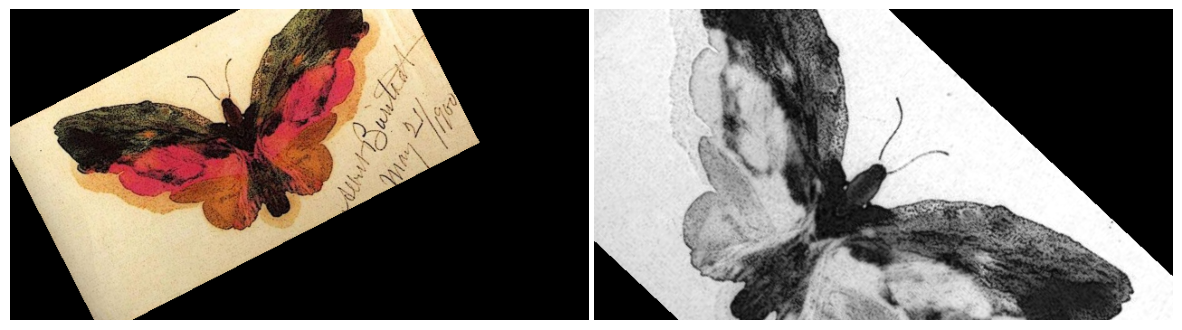

In [23]:
img = bgr2rgb(imread('motyl.jpg'))
imgt = it(img); luma = img[:,:,0]; lumat = it(luma)
h,w = img.shape[:2]; plt.figure(figsize=(15,15*h/w))
plt.subplot(1,2,1); plt.imshow(imgt); plt.axis('off')
plt.subplot(1,2,2); plt.imshow(lumat,cmap='gray'); plt.axis('off')
plt.subplots_adjust(wspace=0.01, hspace=0.01); plt.show()

# Configuration of the new experiment

In [24]:
home = 'My\ Drive/Colab\ Notebooks/'
ioc_exp_root = home+'datasets/mnist/experiments/'
ipaths = {
    'experiments': {
        '20K': ioc_exp_root+'20K-2/',
        '60K': ioc_exp_root+'60K-2/',
    },
    'models': {
        '20K': ioc_exp_root+'20K-2/models/',
        '60K': ioc_exp_root+'60K-2/models/',
    },
}

In [25]:
ioc_exp_folder = ipaths['experiments']['20K'] if is_small_dataset\
                    else ipaths['experiments']['60K']
ioc_exp_folder

'My\\ Drive/Colab\\ Notebooks/datasets/mnist/experiments/20K-2/'

In [26]:
series_id = 'series-1'
xpm_gpath = ioc_exp_folder + series_id + '.pck'
mod_gpath = ioc_exp_folder + 'model-'+series_id + '/'
xpm_gpath, mod_gpath

('My\\ Drive/Colab\\ Notebooks/datasets/mnist/experiments/20K-2/series-1.pck',
 'My\\ Drive/Colab\\ Notebooks/datasets/mnist/experiments/20K-2/model-series-1/')

In [27]:
EXP.save(xpm_gpath,elist=[])
elist = EXP.load(xpm_gpath)

Mounted at /content/gdrive/


In [28]:
ex = EXP()
ex_time = ex._time_.replace(' ','_').replace(':','-');
i = ex_time.index('.'); ex_time = ex_time[0:i]; print(f'time: {ex_time}')
ex.model_path = mod_gpath + ex_time  + '.pck'
ex.model_path

time: 2024-07-05_15-06-03


'My\\ Drive/Colab\\ Notebooks/datasets/mnist/experiments/20K-2/model-series-1/2024-07-05_15-06-03.pck'

# Data Provider

In [29]:
class DataProvider(Dataset):
  def __init__(self,path,ext='raw',
               mode='train',
               val=10,
               transforms=None,
               shape=None,
               force_color=False,
               ):
    self.path = path; self.ext = ext; self.mode = mode; self.force_color = force_color
    self.transforms = transforms; self.shape = shape;
    with open(path+'/labels.pck','rb') as f: self.labels = pickle.load(f)
    n = len(self.labels);  self.base = n-int(n*val/100.)
    self.idxes = list(range(n)); random.shuffle(self.idxes)
    self.nlabels = n if mode=='test' else n-self.base if mode=='val' else\
                    self.base
  def __len__(self): return self.nlabels
  def __getitem__(self,idx): return __getitem__(self,idx)

In [30]:
def __getitem__(self, idx):
  idx_true = self.idxes[self.base+idx] if self.mode=='val' else self.idxes[idx]
  fpath = self.path+'/'+str(idx_true)+'.'+self.ext
  if self.ext!='raw': img = imread(fpath);
  else:
    with open(fpath,'rb') as f:
      img = np.frombuffer(f.read(),dtype=np.uint8).reshape(self.shape)
  if (self.transforms is not None) and self.mode=='train': img = self.transforms(img)
  if self.force_color and len(img.shape)==2: img = np.stack([img,img,img],axis=-1)
  if len(img.shape)==3: img = img.transpose([2,0,1])
  shp = img.shape; toshape = (1,*shp) if len(shp)==2 else shp
  img = img.astype(np.float32).reshape(*toshape)/255
  image = torch.from_numpy(img).to(device)
  label = torch.tensor(int(self.labels[idx_true]),dtype=torch.long)
  return label,image

In [31]:
it = IT.ImageTransforms(rotation_range=15,zoom_range=(0.9,1.1),
  width_shift_range=0.1,height_shift_range=0.1,
  bilinear_by = 'Cython', cython_interpolator=interpolate_bilinearly_cy)

In [32]:
dp = DataProvider('train',ext='raw',mode='train',transforms=None,
                  shape=(28,28),force_color=False)
nitems = dp.__len__(); print('number of training examples:',nitems)

number of training examples: 18000


torch.Size([1, 28, 28])
image class: 0


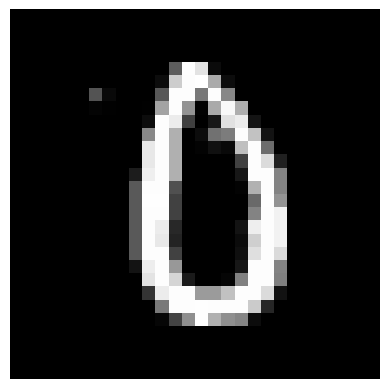

In [33]:
label,image = dp[int(nitems*random.random())]

print(image.shape)
print('image class:',label.item())
img = image.squeeze().cpu().numpy()
if len(img.shape)==3: img = img.transpose([1,2,0])
if len(img.shape)==2: plt.imshow(img,cmap='gray')
else: plt.imshow(img)
plt.axis('off'); plt.show()

# Creating batch of random learning data

In [34]:
ex.batch_size = 54

ex.ext = 'raw'
ex.shp = (28,28); ex.force_color = False

In [35]:
ex.tr = dict(rotation_range=15,zoom_range=0.1,
             width_shift_range=0.1,height_shift_range=0.1,
            bilinear_by = 'Cython')

In [36]:
ex.is_small_dataset = is_small_dataset

In [37]:
train_data = DataProvider('train',ext=ex.ext,mode='train',transforms=None,shape=ex.shp,
                          force_color=ex.force_color)
train_gen = torch.utils.data.DataLoader(dataset = train_data,
                                             batch_size = ex.batch_size,
                                             shuffle = True)

val_data =  DataProvider('train',ext=ex.ext,mode='val',transforms=None,shape=ex.shp,
                          force_color=ex.force_color)
val_gen = torch.utils.data.DataLoader(dataset = val_data,
                                      batch_size = ex.batch_size,
                                      shuffle = False)

test_data = DataProvider('test',ext=ex.ext,mode='test',transforms=None,shape=ex.shp,
                          force_color=ex.force_color)
test_gen = torch.utils.data.DataLoader(dataset = test_data,
                                      batch_size = ex.batch_size,
                                      shuffle = False)

# Defining CNN model

Creating 4 different models with different number of convolution layers

In [38]:
# number of network
ex.inet = 3

In [39]:
ex.num_classes = 10
ex.image_depth = image_depth = train_data[0][1].shape[0]

In [40]:
class Net_0(nn.Module):
  def __init__(self,cres=image_depth,num_filters=32,final_feat=256,num_classes=10,drop=-1):
    super(Net_0,self).__init__()
    nf = [num_filters, 2*num_filters,]; self.drop = drop
    self.conv1 = nn.Conv2d(cres,nf[0],3,stride=2); xres = (28-3+2)//2
    self.bn1 = nn.BatchNorm2d(nf[0])
    self.conv2 = nn.Conv2d(nf[0],nf[1],3,stride=2); xres  = (xres-3+2)//2
    self.bn2 = nn.BatchNorm2d(nf[1])
    print('resolution reduced to:',xres)
    if drop>0: self.d = nn.Dropout(drop)
    self.fc1 = nn.Linear(nf[-1]*xres*xres, final_feat)
    self.fc2 = nn.Linear(final_feat, num_classes)
  def forward(self,x):
    x = self.bn1(F.relu(self.conv1(x)))
    x = self.bn2(F.relu(self.conv2(x)))
    x = torch.flatten(x, start_dim=1)
    if self.drop: x = self.d(x)
    out = self.fc2(F.relu(self.fc1(x)))
    return out

In [41]:
if ex.inet==0:
  ex.num_filters = 32
  ex.final_feat = 512
  ex.drop = 0.2
  net = Net_0(num_filters=ex.num_filters,final_feat=ex.final_feat,drop=ex.drop)

Parameters for other networks

In [42]:
if ex.inet==1:
  flist = (ex.image_depth,32,64,128); klists=((5,),(5,)); slists = ((2,),(2,))
  plists = ((False,),(False,)); dlist = (-1,.4,.4)
  outres = 4

In [43]:
if ex.inet==2:
  flist = (ex.image_depth,32,64,128); klists=((5,5),(5,5)); slists = ((1,2),(1,2))
  plists = ((False,True),(False,True)); dlist = (-1,0.4,0.4)
  outres = 4

In [44]:
if ex.inet==3:
  flist = (ex.image_depth,32,64,128); klists=((3,3,5),(3,3,5)); slists = ((1,1,2),(1,1,2))
  plists = ((False,False,True),(False,False,True)); dlist = (-1,0.4,0.4)
  outres = 4

In [45]:
class Conv2dComponent(nn.Module):
  def __init__(self,nf_in,nf_out,klist,slist=None,plist=None):
    super(Conv2dComponent,self).__init__()
    self.convs = nn.ModuleList(); self.bns = nn.ModuleList()
    for i,k in enumerate(klist):
      nf = nf_out if i else nf_in
      s = slist[i] if slist else 1
      p = k-1 if (plist and plist[i]) else 0
      self.convs.append(nn.Conv2d(nf,nf_out,k,stride=s,padding=p//2))
      self.bns.append(nn.BatchNorm2d(nf_out))
  def forward(self,x):
    for i,conv in enumerate(self.convs):
      x = self.bns[i](F.relu(conv(x)))
    return x

In [46]:
class PureConv2dNet(nn.Module):
  def __init__(self,flist,klists,outres, # = 4
               slists=None,plists=None,dlist=None,nclasses=10):
    super(PureConv2dNet,self).__init__()
    self.convcomps = nn.ModuleList(); self.d1s = nn.ModuleList()
    for i,klist in enumerate(klists):
      slist = slists[i] if slists else None
      plist = plists[i] if plists else None
      self.convcomps.append(Conv2dComponent(flist[i],flist[i+1],klist,
                                            slist=slist,plist=plist))
      if dlist and dlist[i]>0: self.d1s.append(nn.Dropout(dlist[i]))
      else: self.d1s.append(None)
    self.d2 = nn.Dropout(dlist[-1]) if (dlist and dlist[-1]>0) else None
    self.conv = nn.Conv2d(flist[-2],flist[-1],outres)
    self.fc = nn.Linear(flist[-1], nclasses)
  def forward(self,x):
    for i,convcomp in enumerate(self.convcomps):
      x = self.d1s[i](x) if self.d1s[i] else x; x = convcomp(x)
    x = self.d2(x) if self.d2 else x; x = self.conv(x)
    x = torch.flatten(x, start_dim=1)
    y = self.fc(x); return y

In [47]:
if ex.inet>0:
  ex.net_structure = dict(feature_maps=flist, kernels=klists, sampling_strides=slists,
    padding_flags=plists, dropouts=dlist, output_resolution=outres)
  net = PureConv2dNet(flist,klists,outres,slists=slists,plists=plists,dlist=dlist)

In [48]:
net.to(device)

PureConv2dNet(
  (convcomps): ModuleList(
    (0): Conv2dComponent(
      (convs): ModuleList(
        (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
        (1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
        (2): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
      )
      (bns): ModuleList(
        (0-2): 3 x BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): Conv2dComponent(
      (convs): ModuleList(
        (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
        (1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
        (2): Conv2d(64, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
      )
      (bns): ModuleList(
        (0-2): 3 x BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
  )
  (d1s): ModuleList(
    (0): None
    (1): Dropout(p=0.4, inplace=False)
  )
  (d2): Dropout(p=0.4, inplace=False)
  (conv): Conv2d(64, 128, kerne

In [49]:
print("Model state:")
for paramt in net.state_dict(): print(paramt, "\t", net.state_dict()[paramt].size())
print('number of trainable parameters in the net:',
       sum(p.numel() for p in net.parameters() if p.requires_grad))

Model state:
convcomps.0.convs.0.weight 	 torch.Size([32, 1, 3, 3])
convcomps.0.convs.0.bias 	 torch.Size([32])
convcomps.0.convs.1.weight 	 torch.Size([32, 32, 3, 3])
convcomps.0.convs.1.bias 	 torch.Size([32])
convcomps.0.convs.2.weight 	 torch.Size([32, 32, 5, 5])
convcomps.0.convs.2.bias 	 torch.Size([32])
convcomps.0.bns.0.weight 	 torch.Size([32])
convcomps.0.bns.0.bias 	 torch.Size([32])
convcomps.0.bns.0.running_mean 	 torch.Size([32])
convcomps.0.bns.0.running_var 	 torch.Size([32])
convcomps.0.bns.0.num_batches_tracked 	 torch.Size([])
convcomps.0.bns.1.weight 	 torch.Size([32])
convcomps.0.bns.1.bias 	 torch.Size([32])
convcomps.0.bns.1.running_mean 	 torch.Size([32])
convcomps.0.bns.1.running_var 	 torch.Size([32])
convcomps.0.bns.1.num_batches_tracked 	 torch.Size([])
convcomps.0.bns.2.weight 	 torch.Size([32])
convcomps.0.bns.2.bias 	 torch.Size([32])
convcomps.0.bns.2.running_mean 	 torch.Size([32])
convcomps.0.bns.2.running_var 	 torch.Size([32])
convcomps.0.bns.2.num_b

In [50]:
loss_function = nn.CrossEntropyLoss()

In [51]:
ex.lr = 5*1e-2

In [52]:
optimizer = torch.optim.Adam( net.parameters(), lr=ex.lr)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lambda epoch: ex.lr*0.95**epoch)

# Training

In [53]:
def train(net,tgen,vgen,loss_function,optimizer,scheduler,batch_size,num_epochs):
  h = {'tloss_e': [], 'vloss_e': [], 'tacc_e': [], 'vacc_e': [], }; max_vacc = -1.
  for epoch in range(num_epochs):
    nitems = 0; tloss = 0.0; tacc = 0
    for i,(labels,images) in enumerate(tgen):
      labels = labels.to(device)
      outputs = net(images); optimizer.zero_grad()
      loss = loss_function(outputs, labels); loss.backward()
      optimizer.step()
      _, predicted = torch.max(outputs,1); tacc += (predicted == labels).sum()
      nitems += labels.size(0); tloss += loss
      if (i+1) % 500 == 0:
        print('epoch [{}/{}], batch [{}/{}], current mean loss: {:.5f}'\
        .format(epoch+1, num_epochs, i+1,len(tgen),tloss/(i+1)))
    scheduler.step()
    vloss_n, vacc_n = validate(net,loss_function,vgen)
    h['vloss_e'].append(vloss_n); h['vacc_e'].append(vacc_n)
    tloss_n, tacc_n = validate(net, loss_function,tgen)
    h['tloss_e'].append(tloss_n); h['tacc_e'].append(tacc_n)
    if vacc_n>max_vacc and epoch>0:
      save_model(ex,net,h,fiow.ioc); max_vacc = vacc_n
    print(('epoch [{}/{}], mean loss->(train: {:.5f}, val: {:.5f}), '+\
          'success rate->(train: {:.2f}%, val: {:.2f}%)').format(epoch+1, num_epochs,\
          tloss_n,vloss_n,100*tacc_n,100*vacc_n))
  return h

In [54]:
def validate(net,loss_function,gen):
  with torch.no_grad():
    vloss = 0.0; correct = 0; nitems = 0
    for labels,images in gen:
      labels = labels.to(device); nitems += labels.size(0)
      outputs = net(images)
      loss = loss_function(outputs, labels); vloss += loss.data.item()
      _, predicted = torch.max(outputs,1); correct += (predicted == labels).sum()
    return vloss/len(gen), correct.data.item()/nitems

In [55]:
def test(net,gen):
  correct = 0; nitems = 0
  with torch.no_grad():
    for labels,images in gen:
      labels = labels.to(device); nitems += labels.size(0)
      outputs = net(images)
      _, predicted = torch.max(outputs,1); correct += (predicted == labels).sum()
  return correct/nitems

### Learning loop

In [56]:
ex.num_epochs = 30

In [57]:
print(ex)
EXP.save(xpm_gpath,elist=ex)

  _time_: 2024-07-05 15:06:03.502586
  batch_size: 54
  ext: raw
  force_color: False
  image_depth: 1
  inet: 3
  is_small_dataset: True
  lr: 0.05
  model_path: My\ Drive/Colab\ Notebooks/datasets/mnist/experiments/20K-2/model-series-1/2024-07-05_15-06-03.pck
  net_structure: {'feature_maps': (1, 32, 64, 128), 'kernels': ((3, 3, 5), (3, 3, 5)), 'sampling_strides': ((1, 1, 2), (1, 1, 2)), 'padding_flags': ((False, False, True), (False, False, True)), 'dropouts': (-1, 0.4, 0.4), 'output_resolution': 4}
  num_classes: 10
  num_epochs: 30
  shp: (28, 28)
  tr: {'rotation_range': 15, 'zoom_range': 0.1, 'width_shift_range': 0.1, 'height_shift_range': 0.1, 'bilinear_by': 'Cython'}


In [58]:
def save_model(ex,net,h,ioc):
  torch.save({
      'experiment': ex,
      'history': h,
      'net state dict': net.state_dict(),
      'optimizer state dict': optimizer.state_dict()
    }, 'model.pck')
  try:
    ioc.cg('model.pck',ex.model_path)
  except: raise Exception('Path '+ex.model_path+\
                          ' is wrong\nit seems that model folder is not created yet!')
def load_model(ex,net,ioc):
  print('ioc model folder:', ex.model_path)
  try:
    ioc.gc(ex.model_path,'model.pck')
  except: raise Exception('Path '+ex.model_path+\
                          ' is wrong\nit seems that model folder is not created yet!')
  cpoint = torch.load('model.pck')
  net.load_state_dict(cpoint['net state dict'])
  optimizer.load_state_dict(cpoint['optimizer state dict'])
  return cpoint['experiment'], cpoint['history']

In [59]:
beg = time()
history = train(net,train_gen,val_gen,
      loss_function,optimizer,scheduler,
      ex.batch_size,ex.num_epochs)
end = time(); print(f'Learning time: {int(.5+end-beg)}')

epoch [1/30], mean loss->(train: 0.11855, val: 0.10466), success rate->(train: 96.36%, val: 96.55%)
epoch [2/30], mean loss->(train: 0.07695, val: 0.08566), success rate->(train: 97.54%, val: 97.70%)
epoch [3/30], mean loss->(train: 0.06864, val: 0.06595), success rate->(train: 97.81%, val: 97.75%)
epoch [4/30], mean loss->(train: 0.05189, val: 0.04804), success rate->(train: 98.34%, val: 98.30%)
epoch [5/30], mean loss->(train: 0.03679, val: 0.03163), success rate->(train: 98.87%, val: 98.75%)
epoch [6/30], mean loss->(train: 0.04482, val: 0.03942), success rate->(train: 98.57%, val: 98.60%)
epoch [7/30], mean loss->(train: 0.04164, val: 0.04086), success rate->(train: 98.71%, val: 98.55%)
epoch [8/30], mean loss->(train: 0.02612, val: 0.02209), success rate->(train: 99.21%, val: 99.05%)
epoch [9/30], mean loss->(train: 0.02608, val: 0.02257), success rate->(train: 99.19%, val: 99.30%)
epoch [10/30], mean loss->(train: 0.03372, val: 0.04264), success rate->(train: 98.89%, val: 98.85%)

# Testing

In [60]:
test_acc = test(net,test_gen)
test_acc = test_acc.cpu()
print(test_acc,type(test_acc))
ex.acc_test = float(test_acc)
print(ex.acc_test,type(ex.acc_test))

tensor(0.9908) <class 'torch.Tensor'>
0.9907999634742737 <class 'float'>


In [61]:
ex.loss_train = history['tloss_e'][-1]; ex.loss_val = history['vloss_e'][-1]
ex.acc_train = history['tacc_e'][-1]; ex.acc_val = history['vacc_e'][-1]

In [62]:
print('Trained on 54K or on 18K:',
      '18K!' if ex.is_small_dataset else '54K!')
print('Success rate in testing for last model: {:.2f}%'.format(100*ex.acc_test))
print('Success rate in training for last epoch: {:.2f}%'.format(100*ex.acc_train))
print('Success rate in validation for last epoch: {:.2f}%'.format(100*ex.acc_val))

Trained on 54K or on 18K: 18K!
Success rate in testing for last model: 99.08%
Success rate in training for last epoch: 99.87%
Success rate in validation for last epoch: 99.65%


In [63]:
ex_best,history_best = load_model(ex,net,fiow.ioc)

ioc model folder: My\ Drive/Colab\ Notebooks/datasets/mnist/experiments/20K-2/model-series-1/2024-07-05_15-06-03.pck


In [64]:
test_acc = test(net,test_gen)
test_acc = test_acc.cpu()
print(test_acc,type(test_acc))
ex.acc_test = float(test_acc)
print(ex.acc_test,type(ex.acc_test))

tensor(0.9886) <class 'torch.Tensor'>
0.988599956035614 <class 'float'>


In [65]:
ex.best_loss_train = history_best['tloss_e'][-1]; ex.best_loss_val = history_best['vloss_e'][-1]
ex.best_acc_train = history_best['tacc_e'][-1]; ex.best_acc_val = history_best['vacc_e'][-1]

In [66]:
print('Trained on 54K or on 18K:',
      '18K!' if ex.is_small_dataset else '54K!')
print('Success rate in testing for best model: {:.2f}%'.format(100*ex.acc_test))
print('Best success rate in training: {:.2f}%'.format(100*ex.best_acc_train))
print('Best success rate in validation: {:.2f}%'.format(100*ex.best_acc_val))

Trained on 54K or on 18K: 18K!
Success rate in testing for best model: 98.86%
Best success rate in training: 99.87%
Best success rate in validation: 99.90%


In [67]:
def plot_loss_acc(h,num_epochs,test_acc):
  fig,(ax0,ax1) = plt.subplots(2,1,figsize=(8,16))
  ax0.plot(range(1,num_epochs+1),h['tloss_e'],label='training loss on epoch')
  ax0.plot(range(1,num_epochs+1),h['vloss_e'],label='validation loss on epoch')
  ax0.legend(loc='upper right')
  ax1.plot(range(-3,num_epochs+4),[test_acc]*(num_epochs+7),'m',
           label='test accuracy level')
  ax1.plot(range(1,num_epochs+1),h['tacc_e'],label='training accuracy on epoch')
  ax1.plot(range(1,num_epochs+1),h['vacc_e'],label='validation accuracy on epoch')
  ax1.legend(loc='lower right')
  plt.subplots_adjust(hspace=0.15); plt.show()

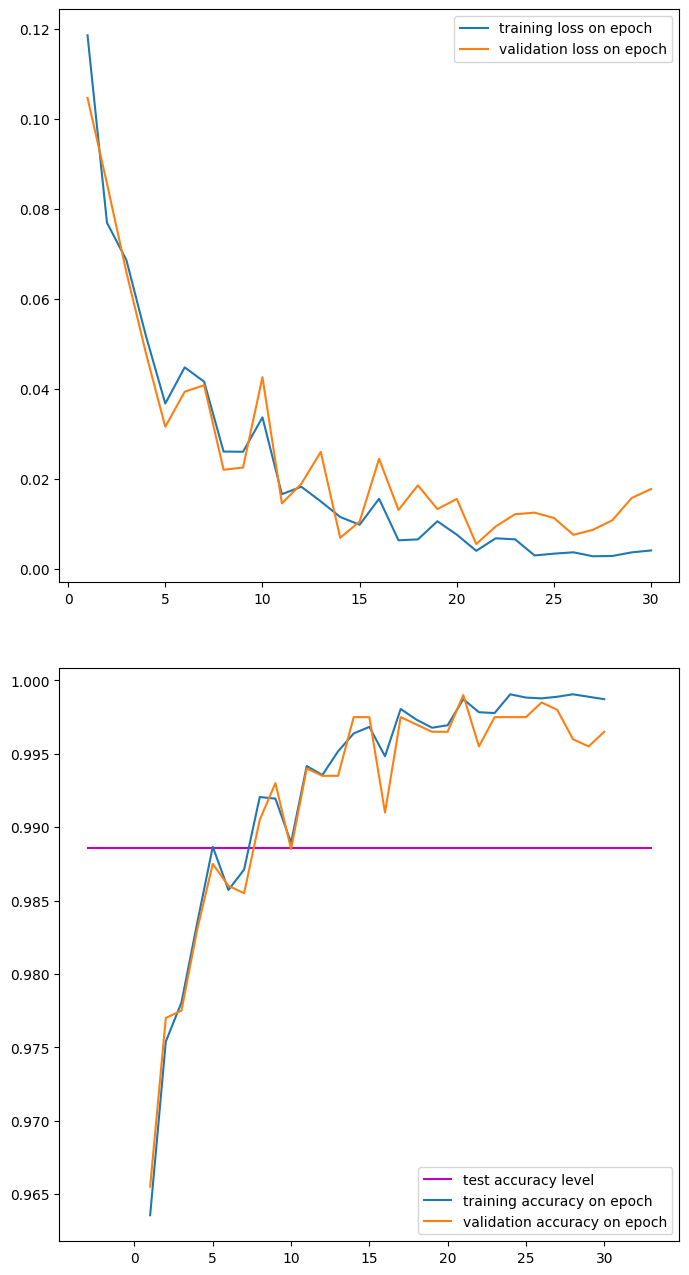

In [68]:
plot_loss_acc(history,ex.num_epochs,test_acc)

In [69]:
print(ex)
EXP.save(xpm_gpath,elist=ex)

  _time_: 2024-07-05 15:06:03.502586
  acc_test: 0.988599956035614
  acc_train: 0.9987222222222222
  acc_val: 0.9965
  batch_size: 54
  best_acc_train: 0.9987222222222222
  best_acc_val: 0.999
  best_loss_train: 0.004089410382227571
  best_loss_val: 0.005593500293343823
  ext: raw
  force_color: False
  image_depth: 1
  inet: 3
  is_small_dataset: True
  loss_train: 0.004166956361692274
  loss_val: 0.017825554974401234
  lr: 0.05
  model_path: My\ Drive/Colab\ Notebooks/datasets/mnist/experiments/20K-2/model-series-1/2024-07-05_15-06-03.pck
  net_structure: {'feature_maps': (1, 32, 64, 128), 'kernels': ((3, 3, 5), (3, 3, 5)), 'sampling_strides': ((1, 1, 2), (1, 1, 2)), 'padding_flags': ((False, False, True), (False, False, True)), 'dropouts': (-1, 0.4, 0.4), 'output_resolution': 4}
  num_classes: 10
  num_epochs: 30
  shp: (28, 28)
  tr: {'rotation_range': 15, 'zoom_range': 0.1, 'width_shift_range': 0.1, 'height_shift_range': 0.1, 'bilinear_by': 'Cython'}
